In [1]:
%matplotlib inline

In [2]:
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import matplotlib.animation as mpla
import requests
import json
from pprint import pprint
import geopandas as gpd

# from shapely.geometry import shape, Point

# Find out charge status percentages by LGA

In [3]:
xlsx = pd.ExcelFile("./Data/Data_Tables_LGA_Criminal_Incidents_Year_Ending_September_2021.xlsx")
charge_status_df = pd.read_excel(xlsx, "Table 05")
charge_status_df

,Year,Year ending,Local Government Area,Charge Status,Incidents Recorded
0,2021,September,Alpine,Charges laid,153
1,2021,September,Alpine,No charges laid,111
2,2021,September,Alpine,Unsolved,107
3,2021,September,Ararat,Charges laid,625
4,2021,September,Ararat,No charges laid,250
...,...,...,...,...,...
2365,2012,September,Yarra Ranges,No charges laid,841
2366,2012,September,Yarra Ranges,Unsolved,2677
2367,2012,September,Yarriambiack,Charges laid,125
2368,2012,September,Yarriambiack,No charges laid,69


In [4]:
# combining charges laid and no charges laid to Solved status
charge_status_df["Charge Status"] = charge_status_df["Charge Status"].str.replace("Charges laid" , "Solved")
charge_status_df["Charge Status"] = charge_status_df["Charge Status"].str.replace("No charges laid" , "Solved")
charge_status_df

,Year,Year ending,Local Government Area,Charge Status,Incidents Recorded
0,2021,September,Alpine,Solved,153
1,2021,September,Alpine,Solved,111
2,2021,September,Alpine,Unsolved,107
3,2021,September,Ararat,Solved,625
4,2021,September,Ararat,Solved,250
...,...,...,...,...,...
2365,2012,September,Yarra Ranges,Solved,841
2366,2012,September,Yarra Ranges,Unsolved,2677
2367,2012,September,Yarriambiack,Solved,125
2368,2012,September,Yarriambiack,Solved,69


In [5]:
charge_by_types = charge_status_df.groupby(["Local Government Area", "Year","Charge Status"])
total_incidents = charge_status_df.groupby(["Local Government Area", "Year"])
charge_by_types_df = pd.DataFrame({"Incidents Combined" : charge_by_types["Incidents Recorded"].sum().astype(int)})

charge_by_types_df["Total Incidents"] = total_incidents["Incidents Recorded"].sum().astype(int)
charge_by_types_df.reset_index(level = [0,1,2], inplace= True)                                
charge_by_types_df

,Local Government Area,Year,Charge Status,Incidents Combined,Total Incidents
0,Alpine,2012,Solved,196,311
1,Alpine,2012,Unsolved,115,311
2,Alpine,2013,Solved,219,336
3,Alpine,2013,Unsolved,117,336
4,Alpine,2014,Solved,218,316
...,...,...,...,...,...
1575,Yarriambiack,2019,Unsolved,92,303
1576,Yarriambiack,2020,Solved,222,335
1577,Yarriambiack,2020,Unsolved,113,335
1578,Yarriambiack,2021,Solved,201,319


In [6]:
# Calculate percentage charge status:
charge_by_types_df["Status Percentage"] = round(charge_by_types_df["Incidents Combined"] / charge_by_types_df["Total Incidents"] * 100, 2)
charge_by_types_df

,Local Government Area,Year,Charge Status,Incidents Combined,Total Incidents,Status Percentage
0,Alpine,2012,Solved,196,311,63.02
1,Alpine,2012,Unsolved,115,311,36.98
2,Alpine,2013,Solved,219,336,65.18
3,Alpine,2013,Unsolved,117,336,34.82
4,Alpine,2014,Solved,218,316,68.99
...,...,...,...,...,...,...
1575,Yarriambiack,2019,Unsolved,92,303,30.36
1576,Yarriambiack,2020,Solved,222,335,66.27
1577,Yarriambiack,2020,Unsolved,113,335,33.73
1578,Yarriambiack,2021,Solved,201,319,63.01


# Combine police stations number and charge status

In [7]:
population_df =  pd.read_csv("./output_data/Population_by_LGA_2012-2021.csv")

In [8]:
population_df

,Year,Local Government Area,Total Population
0,2012,Alpine,12182
1,2012,Ararat,11399
2,2012,Ballarat,96727
3,2012,Banyule,123583
4,2012,Bass Coast,30811
...,...,...,...
785,2021,Wodonga,43147
786,2021,Wyndham,290654
787,2021,Yarra,100852
788,2021,Yarra Ranges,159102


In [9]:
charge_status_df = pd.merge(population_df, charge_by_types_df , how = "right", on = ["Year", "Local Government Area"])
charge_status_df

,Year,Local Government Area,Total Population,Charge Status,Incidents Combined,Total Incidents,Status Percentage
0,2012,Alpine,12182,Solved,196,311,63.02
1,2012,Alpine,12182,Unsolved,115,311,36.98
2,2013,Alpine,12282,Solved,219,336,65.18
3,2013,Alpine,12282,Unsolved,117,336,34.82
4,2014,Alpine,12354,Solved,218,316,68.99
...,...,...,...,...,...,...,...
1575,2019,Yarriambiack,6636,Unsolved,92,303,30.36
1576,2020,Yarriambiack,6587,Solved,222,335,66.27
1577,2020,Yarriambiack,6587,Unsolved,113,335,33.73
1578,2021,Yarriambiack,6445,Solved,201,319,63.01


In [10]:
charge_status_df = charge_status_df.loc[charge_status_df["Year"] == 2021]
charge_status_df

,Year,Local Government Area,Total Population,Charge Status,Incidents Combined,Total Incidents,Status Percentage
18,2021,Alpine,13098,Solved,264,371,71.16
19,2021,Alpine,13098,Unsolved,107,371,28.84
38,2021,Ararat,12004,Solved,875,1134,77.16
39,2021,Ararat,12004,Unsolved,259,1134,22.84
58,2021,Ballarat,113350,Solved,3727,7455,49.99
...,...,...,...,...,...,...,...
1539,2021,Yarra,100852,Unsolved,5382,9760,55.14
1558,2021,Yarra Ranges,159102,Solved,3137,5323,58.93
1559,2021,Yarra Ranges,159102,Unsolved,2186,5323,41.07
1578,2021,Yarriambiack,6445,Solved,201,319,63.01


In [11]:
police_stations_df = pd.read_csv("./output_data/Number_of_police_stations_in_each_LGA_2021.csv")

In [12]:
charge_status_df = pd.merge(police_stations_df, charge_status_df , how = "right", on = "Local Government Area")

charge_status_df = charge_status_df.rename(columns = {"Incidents Combined" : "Incidents Recorded"} )
charge_status_df

,Local Government Area,Police Stations in LGA,Year,Total Population,Charge Status,Incidents Recorded,Total Incidents,Status Percentage
0,Alpine,6,2021,13098,Solved,264,371,71.16
1,Alpine,6,2021,13098,Unsolved,107,371,28.84
2,Ararat,4,2021,12004,Solved,875,1134,77.16
3,Ararat,4,2021,12004,Unsolved,259,1134,22.84
4,Ballarat,5,2021,113350,Solved,3727,7455,49.99
...,...,...,...,...,...,...,...,...
153,Yarra,3,2021,100852,Unsolved,5382,9760,55.14
154,Yarra Ranges,10,2021,159102,Solved,3137,5323,58.93
155,Yarra Ranges,10,2021,159102,Unsolved,2186,5323,41.07
156,Yarriambiack,8,2021,6445,Solved,201,319,63.01


In [13]:
charge_solved_df = charge_status_df.loc[charge_status_df["Charge Status"] == "Solved"]
solved_percentage = charge_solved_df["Status Percentage"]
mean_charge = round(np.mean(solved_percentage),1)
std_charge = round(np.std(solved_percentage, ddof = 0),1)
print(f"The mean solved charge percentage is: {mean_charge}%")
print(f"The median solved charge percentage is: {round(np.median(solved_percentage),1)}%")
print(f"The standard deviation solved charge percentage is: {std_charge}%")

print(f"68% of LGA has solved charge percentage between {mean_charge - std_charge}% and {mean_charge + std_charge}%")
print(f"95% of LGA has solved charge percentage between {mean_charge - 2 * std_charge}% and {mean_charge + 2 * std_charge}%")
print(f"99.7% of LGA has solved charge percentage between {round(mean_charge - 3 * std_charge,1)}% and {mean_charge + 3 * std_charge}%")

The mean solved charge percentage is: 58.5%
The median solved charge percentage is: 59.2%
The standard deviation solved charge percentage is: 10.4%
68% of LGA has solved charge percentage between 48.1% and 68.9%
95% of LGA has solved charge percentage between 37.7% and 79.3%
99.7% of LGA has solved charge percentage between 27.3% and 89.7%


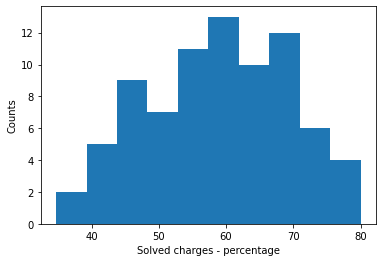

NormaltestResult(statistic=1.8782924790839053, pvalue=0.39096148036435285)


In [14]:
plt.hist(solved_percentage)
plt.xlabel("Solved charges - percentage")
plt.ylabel("Counts")
plt.show()
plt.style.use("default")
print(st.normaltest(solved_percentage.sample(50)))

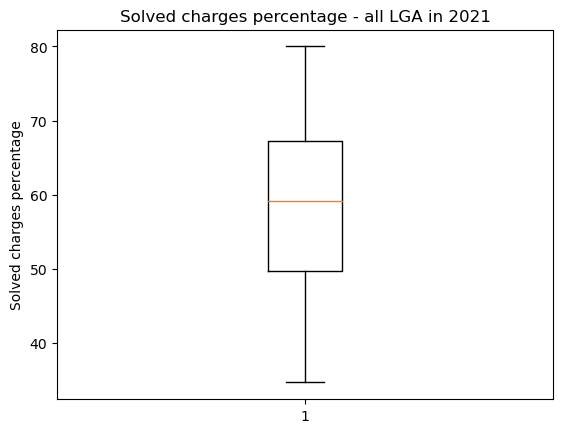

In [15]:
fig , ax = plt.subplots()
ax.set_title("Solved charges percentage - all LGA in 2021")
ax.set_ylabel("Solved charges percentage")
ax.boxplot(solved_percentage)
plt.show()

# Conclusion: the data is normally distributed, no outliner identified

In [16]:
# setting up function to show scatter plot by year
def scatter_plot(df, year, chargetype, col1, col2):
    new_df = df.loc[(df["Charge Status"] == chargetype) & (df["Year"] == year)]
    title = str(f"{col1} vs {col2} \n {chargetype} charges - {year}")
    new_df.plot(col1, col2, kind = "scatter", xlabel = col1, title = title)
                
    (slope, intercept, rvalue, pvalue, stderr) = linregress(new_df[col1],new_df[col2])
    equation = f"y = {round(slope,2)}x + {round(intercept,2)}"
    x = np.arange(0,new_df[col1].max()+1,1)
    y = [slope * x1 + intercept for x1 in x]
    
    plt.plot(x, y, color = "red" )
    plt.tight_layout()
    plt.style.use("Solarize_Light2")
    plt.annotate(equation, (new_df[col1].max()/3*2 , new_df[col2].max()/3), color = "red")
    print(f"r-value is {rvalue}")

r-value is -0.45042637743101116


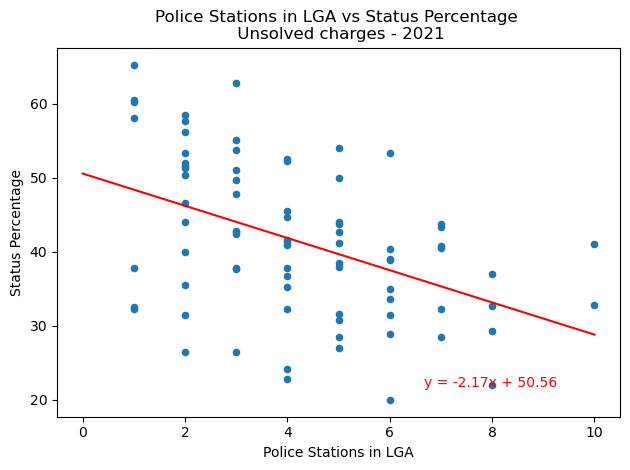

In [17]:
scatter_plot(charge_status_df, 2021, "Unsolved", "Police Stations in LGA","Status Percentage")


r-value is 0.45042637743101116


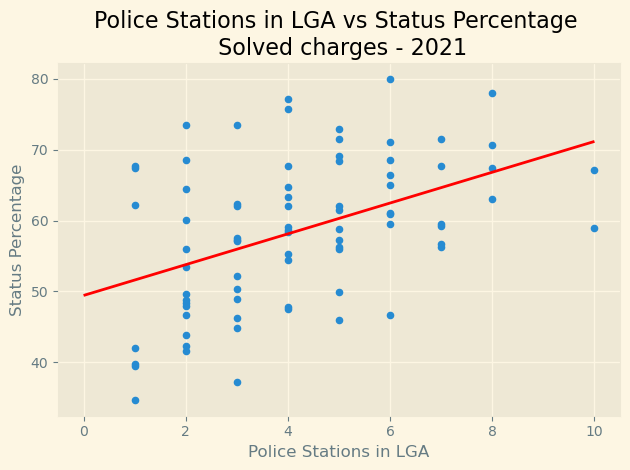

In [18]:
scatter_plot(charge_status_df, 2021, "Solved", "Police Stations in LGA","Status Percentage")

r-value is 0.8649090613317709


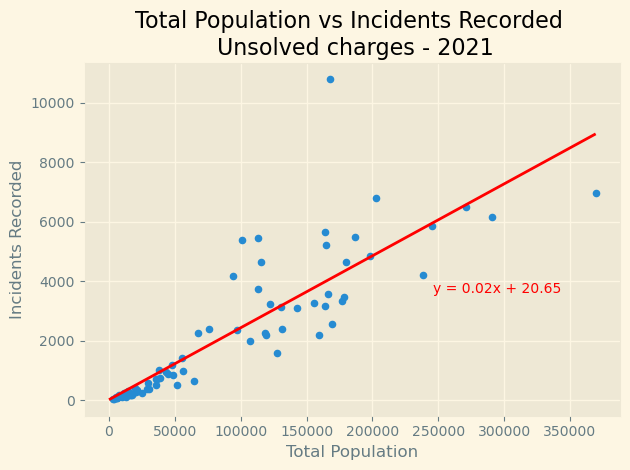

In [19]:
scatter_plot(charge_status_df, 2021, "Unsolved", "Total Population", "Incidents Recorded")

r-value is 0.8115263163424841


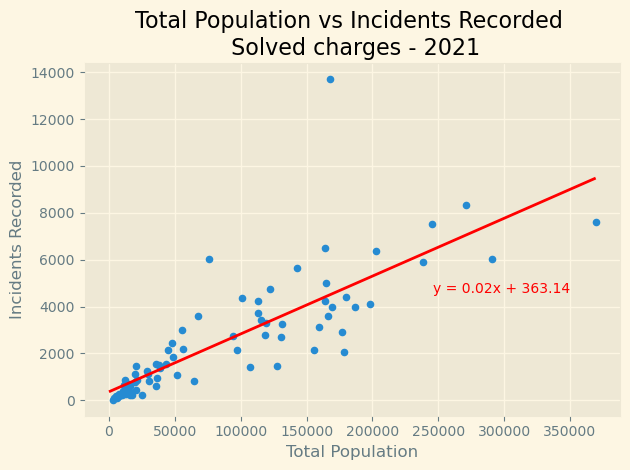

In [20]:
scatter_plot(charge_status_df, 2021, "Solved", "Total Population", "Incidents Recorded")

# Draw LGA boundaries and show charges status on the map

In [21]:
with open('./Data/VMFEAT_POLICE_STATION.json') as f:
    js = json.load(f)

In [22]:
pprint(js)

{'features': [{'geometry': {'coordinates': [145.70777089, -37.18863456],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'EAL',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 134710,
                              'FEATURE_ST': '',
                              'FEATURE_SU': 'police station',
                              'FEATURE_TY': 'emergency facility',
                              'NAME': 'ALEXANDRA POLICE STATION',
                              'NAME_LABEL': 'Alexandra Police Station',
                              'OBJECTID': 1887916,
                              'PARENT_FEA': None,
                              'PARENT_NAM': '',


               'type': 'Feature'},
              {'geometry': {'coordinates': [142.41949945, -35.94324016],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'WBH',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 135508,
                              'FEATURE_ST': '',
                              'FEATURE_SU': 'police station',
                              'FEATURE_TY': 'emergency facility',
                              'NAME': 'BEULAH POLICE STATION',
                              'NAME_LABEL': 'Beulah Police Station',
                              'OBJECTID': 1887939,
                              'PARENT_FEA': None,
                   

                              'NAME': 'BRIDGEWATER POLICE STATION',
                              'NAME_LABEL': 'Bridgewater Police Station',
                              'OBJECTID': 1887947,
                              'PARENT_FEA': None,
                              'PARENT_NAM': '',
                              'PFI': 135820,
                              'STATE': 'VIC',
                              'SUPERCEDED': None,
                              'THEME1': '',
                              'THEME2': '',
                              'VICNAMES_I': 3394,
                              'VICNAMES_S': '10',
                              'VMADD_PFI': '52232932'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [144.96233071, -37.71817406],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'NFK',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000

                              'AUTH_ORG_I': 'WHP',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 138865,
                              'FEATURE_ST': '',
                              'FEATURE_SU': 'police station',
                              'FEATURE_TY': 'emergency facility',
                              'NAME': 'HOPETOUN POLICE STATION',
                              'NAME_LABEL': 'Hopetoun Police Station',
                              'OBJECTID': 1888037,
                              'PARENT_FEA': None,
                              'PARENT_NAM': '',
                              'PFI': 138865,
                              'STATE': 'VIC',
                              'SUPERCEDED': None,
                              '

                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 140215,
                              'FEATURE_ST': '',
                              'FEATURE_SU': 'police station',
                              'FEATURE_TY': 'emergency facility',
                              'NAME': 'MAFFRA POLICE STATION',
                              'NAME_LABEL': 'Maffra Police Station',
                              'OBJECTID': 1888076,
                              'PARENT_FEA': None,
                              'PARENT_NAM': '',
                              'PFI': 140215,
                              'STATE': 'VIC',
                              'SUPERCEDED': None,
                              'THEME1': '',
                              'THEME2': '',
                              'VICNAMES_I': 15876,
                              'VICNAMES_S': '10',
                              'VMADD_PFI': '53260491'},
               'type': 'Feature'}

                              'PARENT_NAM': '',
                              'PFI': 140528,
                              'STATE': 'VIC',
                              'SUPERCEDED': None,
                              'THEME1': '',
                              'THEME2': '',
                              'VICNAMES_I': 16661,
                              'VICNAMES_S': '10',
                              'VMADD_PFI': '51114773'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [142.06265827, -34.16772092],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'WMB',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 14

                              'VMADD_PFI': '134168723'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [145.20341937, -36.05975288],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'ENT',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 141299,
                              'FEATURE_ST': '',
                              'FEATURE_SU': 'police station',
                              'FEATURE_TY': 'emergency facility',
                              'NAME': 'NATHALIA POLICE STATION',
                              'NAME_LABEL': 'Nathalia Police Station',
                              'OBJECTID': 1888115,
        

                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 142060,
                              'FEATURE_ST': '',
                              'FEATURE_SU': 'police station',
                              'FEATURE_TY': 'emergency facility',
                              'NAME': 'PORTARLINGTON POLICE STATION',
                              'NAME_LABEL': 'Portarlington Police Station',
                              'OBJECTID': 1888133,
                              'PARENT_FEA': None,
                              'PARENT_NAM': '',
                              'PFI': 142060,
                              'STATE': 'VIC',
                              'SUPERCEDED': None,
                              'THEME1': '',
                              'THEME2': '',
                              'VICNAMES_I': 21667,
     

                              'OBJECTID': 1888165,
                              'PARENT_FEA': None,
                              'PARENT_NAM': '',
                              'PFI': 142998,
                              'STATE': 'VIC',
                              'SUPERCEDED': None,
                              'THEME1': '',
                              'THEME2': '',
                              'VICNAMES_I': 24262,
                              'VICNAMES_S': '10',
                              'VMADD_PFI': '425956877'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [142.18678013, -34.30404523],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'WRE',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                

                              'VICNAMES_I': 5066,
                              'VICNAMES_S': '10',
                              'VMADD_PFI': '132914321'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [143.34837347, -36.26960541],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'WCN',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 136402,
                              'FEATURE_ST': '',
                              'FEATURE_SU': 'police station',
                              'FEATURE_TY': 'emergency facility',
                              'NAME': 'CHARLTON POLICE STATION',
                              

              {'geometry': {'coordinates': [145.16059418, -37.67408967],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'NDD',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 137176,
                              'FEATURE_ST': '',
                              'FEATURE_SU': 'police station',
                              'FEATURE_TY': 'emergency facility',
                              'NAME': 'DIAMOND CREEK POLICE STATION',
                              'NAME_LABEL': 'Diamond Creek Police Station',
                              'OBJECTID': 1887991,
                              'PARENT_FEA': None,
                              'PARENT_NA

                              'STATE': 'VIC',
                              'SUPERCEDED': None,
                              'THEME1': '',
                              'THEME2': '',
                              'VICNAMES_I': -1384106,
                              'VICNAMES_S': '11',
                              'VMADD_PFI': '422531373'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [145.02589162, -37.64674204],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'NEP',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 137581,
                              'FEATURE_ST': '',
                              'FEAT

                              'THEME1': '',
                              'THEME2': '',
                              'VICNAMES_I': 27312,
                              'VICNAMES_S': '10',
                              'VMADD_PFI': '54609689'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [143.22596515, -36.07445539],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'WWH',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-04-22T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 612814,
                              'FEATURE_ST': '',
                              'FEATURE_SU': 'police station',
                              'FEATURE_TY': 'emergency facility',
       

                              'NAME_LABEL': 'Bayside Police Station',
                              'OBJECTID': 1888224,
                              'PARENT_FEA': None,
                              'PARENT_NAM': '',
                              'PFI': 765066,
                              'STATE': 'VIC',
                              'SUPERCEDED': None,
                              'THEME1': '',
                              'THEME2': '',
                              'VICNAMES_I': -1384109,
                              'VICNAMES_S': '11',
                              'VMADD_PFI': '53632853'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [145.1733094, -38.11479826],
                            'type': 'Point'},
               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'SCD',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                 

               'properties': {'AUTH_ORG_C': '107',
                              'AUTH_ORG_I': 'WLX',
                              'AUTH_ORG_V': '2021-04-20T00:00:00.000Z',
                              'CHILD_EXIS': '',
                              'CREATE_DA0': '2021-11-02T00:00:00.000Z',
                              'CREATE_DAT': '2009-05-21T00:00:00.000Z',
                              'FEATURE_ID': 139945,
                              'FEATURE_ST': '',
                              'FEATURE_SU': 'police station',
                              'FEATURE_TY': 'emergency facility',
                              'NAME': 'LEXTON POLICE STATION',
                              'NAME_LABEL': 'Lexton Police Station',
                              'OBJECTID': 1954095,
                              'PARENT_FEA': None,
                              'PARENT_NAM': '',
                              'PFI': 139945,
                              'STATE': 'VIC',
                              'SUP

In [23]:
# getting LGA boundaries
url = "https://data.gov.au/geoserver/vic-local-government-areas-psma-administrative-boundaries/wfs?request=GetFeature&typeName=ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811&outputFormat=json"
response = requests.get(url).json()


with open('personal.json', 'w') as json_file:
    json.dump(response, json_file)

In [24]:
boundaries = gpd.read_file('./Data/LGA_boundaries.json')

In [25]:
policeStations = gpd.read_file('./Data/VMFEAT_POLICE_STATION.json')

In [26]:
charge_percentage = charge_status_df[["Local Government Area", "Status Percentage"]]

In [27]:
boundaries = boundaries.rename(columns = {"vic_lga__3": "Local Government Area"})

In [28]:
charges_boundaries = pd.merge(boundaries, charge_percentage, how = "left" , on = "Local Government Area")

In [29]:
charges_boundaries["Local Government Area"][3]

'KINGSTON'

In [30]:
charge_percentage["Local Government Area"]

0            Alpine
1            Alpine
2            Ararat
3            Ararat
4          Ballarat
           ...     
153           Yarra
154    Yarra Ranges
155    Yarra Ranges
156    Yarriambiack
157    Yarriambiack
Name: Local Government Area, Length: 158, dtype: object

In [31]:
len(boundaries)

92

boundaries["color"] = 0
boundaries["color"] = np.arange(1,93,1)


Text(0.5, 1.0, 'Police stations in Victoria')

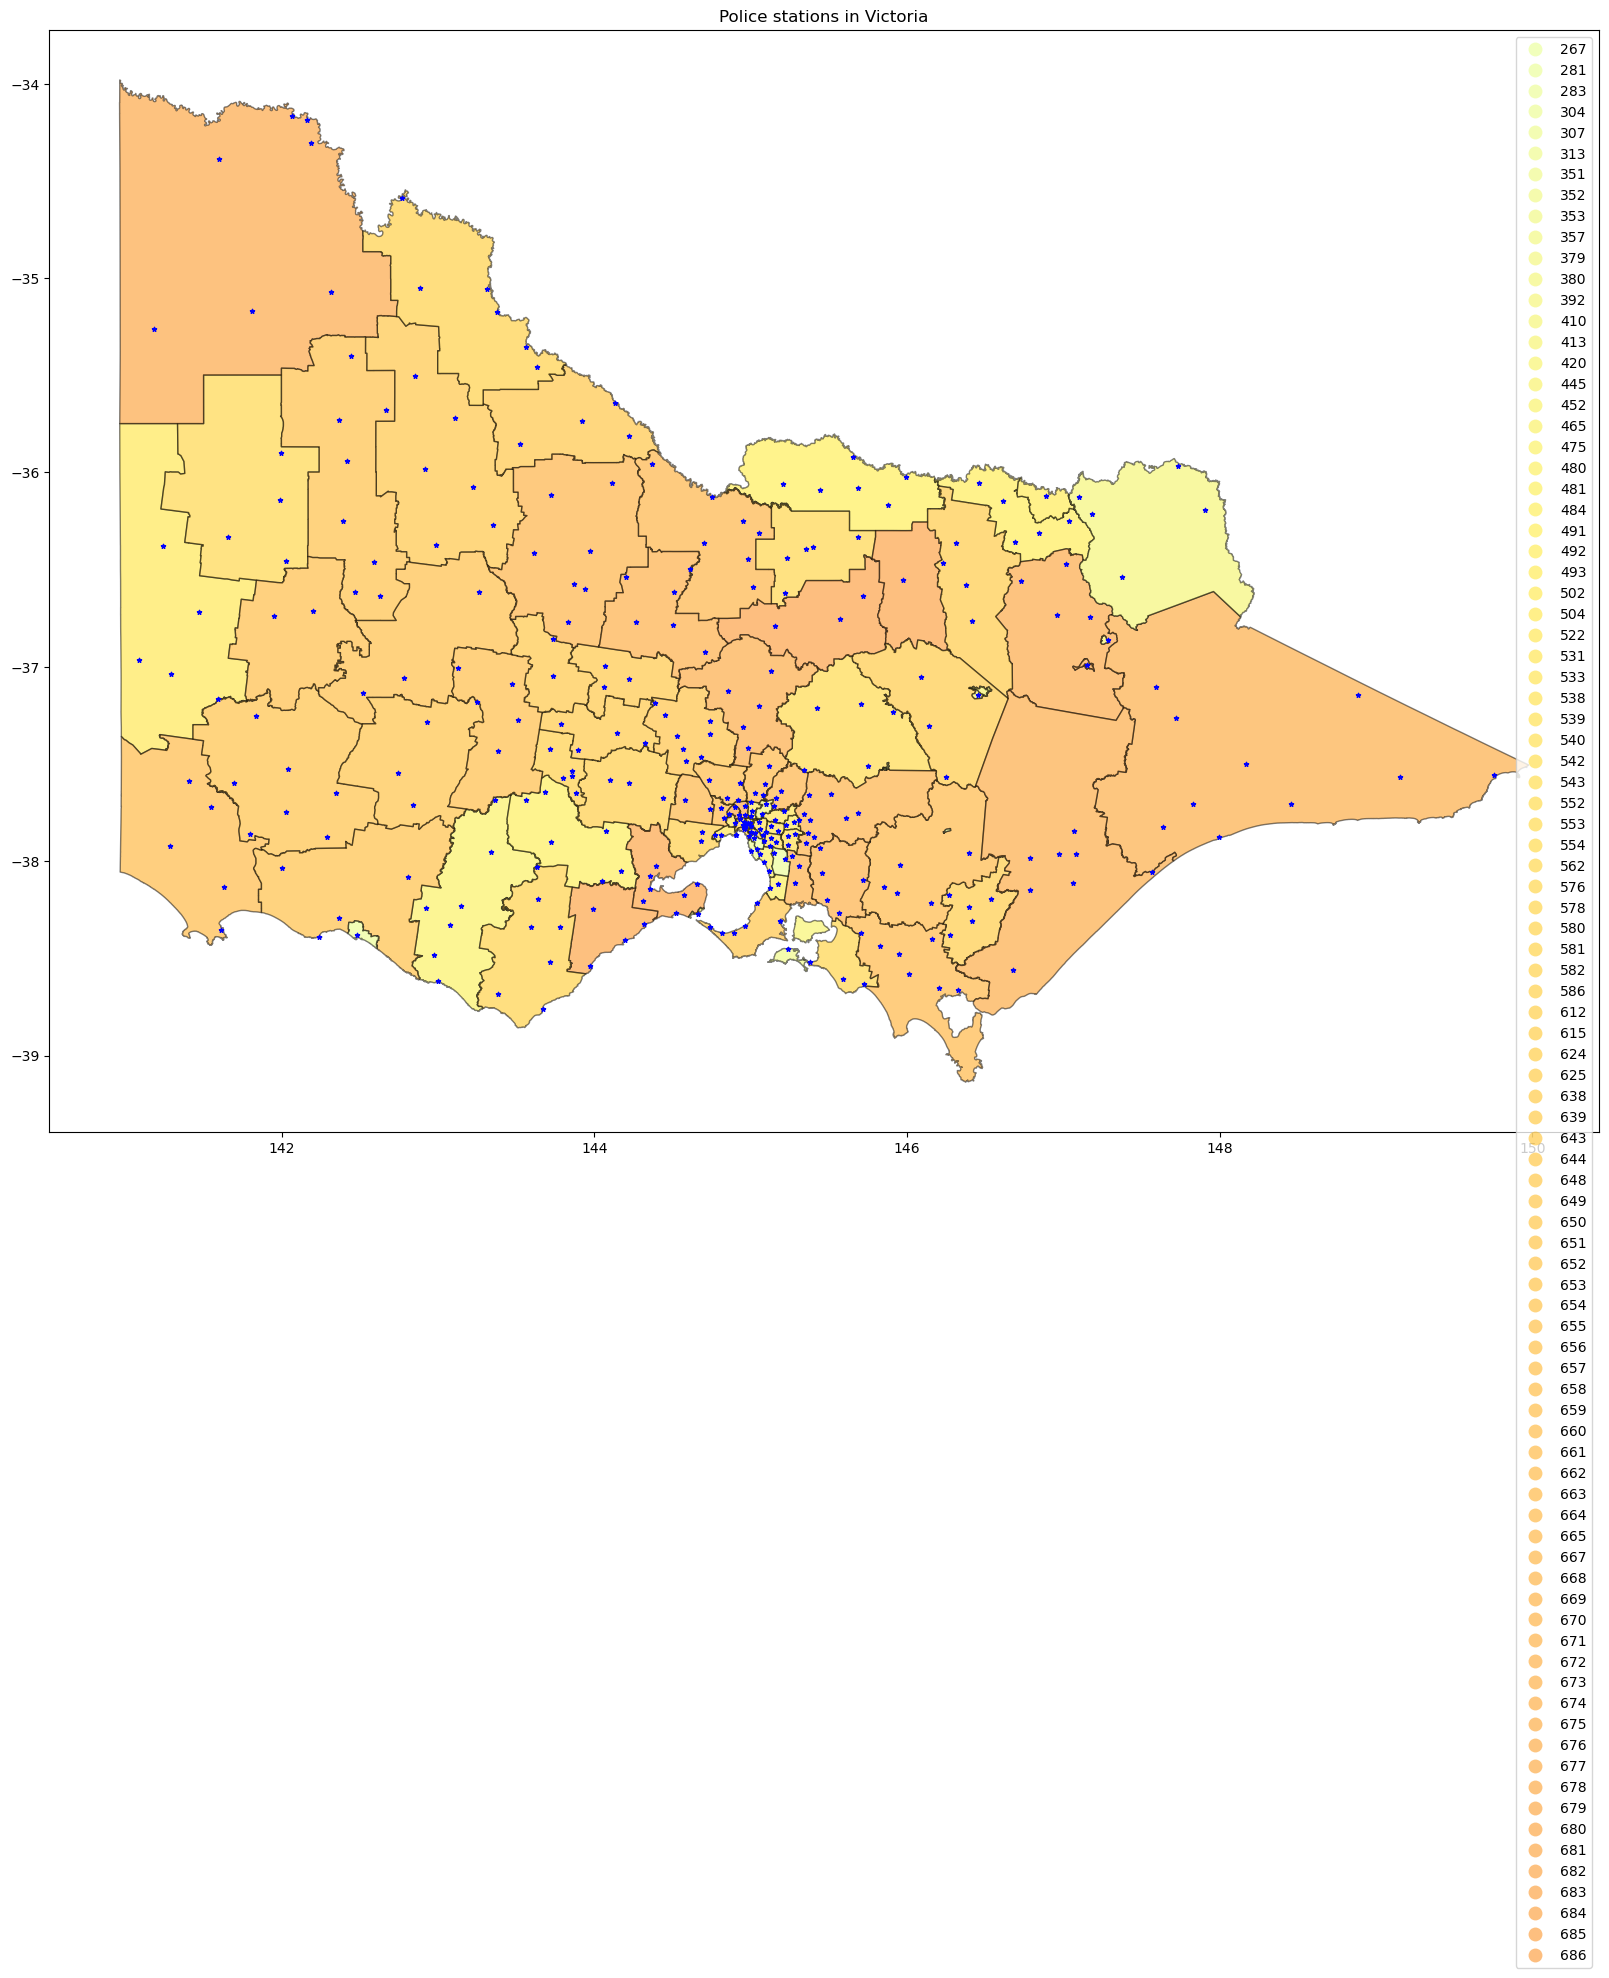

In [41]:
f, ax = plt.subplots(1, figsize = (20,20))
plt.style.use("default")
charges_boundaries.plot("lg_ply_pid", cmap = "Wistia", ax = ax, legend = True, edgecolor = "black", alpha = 0.5,legend_kwds={'loc': "upper right"})
# plt.get_cmap("Wistia")
policeStations.plot(ax = ax, color = "blue", marker = "*", markersize = 10)
plt.title("Police stations in Victoria")
#  plt..legend()

In [34]:
charges_boundaries

,id,lg_ply_pid,dt_create,dt_retire,lga_pid,vic_lga_sh,vic_lga__1,vic_lga__2,Local Government Area,vic_lga__4,vic_lga__5,geometry,Status Percentage
0,ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811.1,452,2017-09-08,None,VIC245,2017-09-08,None,FALLS CREEK ALPINE RESORT (UNINCORPORATED),FALLS CREEK ALPINE RESORT (UNINC),None,2,"MULTIPOLYGON (((147.24172 -36.86703, 147.24202...",NaN
1,ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811.2,465,2017-09-08,None,VIC246,2017-09-08,None,MOUNT BULLER ALPINE RESORT (UNINCORPORATED),MOUNT BULLER ALPINE RESORT (UNINC),None,2,"MULTIPOLYGON (((146.46042 -37.12999, 146.46062...",NaN
2,ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811.3,475,2017-09-08,None,VIC231,2017-09-08,None,CORANGAMITE SHIRE,CORANGAMITE,None,2,"MULTIPOLYGON (((143.47180 -38.28086, 143.47117...",NaN
3,ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811.4,480,2017-09-08,None,VIC226,2017-09-08,None,KINGSTON CITY,KINGSTON,None,2,"MULTIPOLYGON (((145.10925 -38.04438, 145.10912...",NaN
4,ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811.5,481,2017-09-08,None,VIC227,2017-09-08,None,FRANKSTON CITY,FRANKSTON,None,2,"MULTIPOLYGON (((145.10531 -38.15533, 145.10556...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811.88,410,2017-09-08,None,VIC187,2017-09-08,None,TOWONG SHIRE,TOWONG,None,2,"MULTIPOLYGON (((147.30588 -36.73235, 147.30692...",NaN
88,ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811.89,413,2017-09-08,None,VIC238,2017-09-08,None,QUEENSCLIFFE BOROUGH,QUEENSCLIFFE,None,2,"MULTIPOLYGON (((144.60074 -38.28784, 144.60235...",NaN
89,ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811.90,420,2017-09-08,None,VIC251,2017-09-08,None,FRENCH-ELIZABETH-SANDSTONE ISLANDS (UNINC),FRENCH-ELIZABETH-SANDSTONE ISLANDS (UNINC),None,2,"MULTIPOLYGON (((145.45333 -38.30788, 145.45341...",NaN
90,ckan_bdf92691_c6fe_42b9_a0e2_a4cd716fa811.91,445,2017-09-08,None,VIC240,2017-09-08,None,MOUNT STIRLING ALPINE RESORT (UNINCORPORATED),MOUNT STIRLING ALPINE RESORT (UNINC),None,2,"MULTIPOLYGON (((146.45474 -37.12387, 146.45427...",NaN


In [ ]:
boundaries.keys()

In [ ]:
boundaries["Local Government Area"].head(50 )